# Visualising Data

**Authors:**

- [Angus Mackenzie](https://github.com/AngusTheMack) ([1106817](mailto:1106817@students.wits.ac.za))
- [Nathan Michlo](https://github.com/nmichlo) ([1386161](mailto:1386161@students.wits.ac.za))

**Achievement** Using various CNN visualisation techniques we examine how our trained models interect with the input images.

## Introduction
This notebook is based off of techniques from [Pytorch CNN Visualisations](https://github.com/utkuozbulak/pytorch-cnn-visualizations).

----------------------

# Code - Init

**Imports**

In [1]:
# Utilities
import sys
import os
import fastai
import torch
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
%matplotlib inline

# Machine Learning
import torch
import torchvision
# from torchvision import transforms
# import pytorch_lightning as pl
from torch import optim
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from fastai.callbacks.hooks import num_features_model
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm


# Add root of project to PYTHON_PATH so we can import correctly
if os.path.abspath('../') not in {os.path.abspath(path) for path in sys.path}:
    sys.path.insert(0, os.path.abspath('../'))

**SSIC common**

In [2]:
# Import SSIC common stuffs
from ssic.ssic import SSIC
from ssic.util import set_random_seed

# if you dont have a .env file set it here
os.environ.setdefault('DATASET_DIR', '~/downloads/datasets/ssic')

# Initialise SSIC paths, data and other stuffs, searches for a .env file in the project with these variables specified, also checkpoints os.environ and sys.path
SSIC.init()

# SSIC.init is required to locate these imports
from ranger import Ranger
from radam import RAdam
from lookahead import Lookahead
from Mish.Torch.functional import mish
from Mish.Torch.mish import Mish

[LOADED]: 
[STORAGE_DIR]: /home/nmichlo/workspace/snake-id/notebooks/out
[DATASET_DIR]: /home/nmichlo/downloads/datasets/ssic
[DATASET_CLASS_CSV]: /home/nmichlo/downloads/datasets/ssic/class_idx_mapping.csv
[DATASET_TRAIN_DIR]: /home/nmichlo/downloads/datasets/ssic/train
[DATASET_TEST_DIR]: /home/nmichlo/downloads/datasets/ssic/round1


**Util**

In [3]:
from IPython import display

def plt_show_loop():
    # same as plt.show() but cleares all output in the block
    display.display(plt.gcf())
    display.clear_output(wait=True)

-----------------------
# Code - Model

In [4]:
set_random_seed(42)

[SEEDED]: 42


**Create Model**

In [5]:
model_name = 'efficientnet-b0'
save_learner = f'{SSIC.STORAGE_DIR}/{model_name}'

def make_model(load=False):
    # Create Model
    model = EfficientNet.from_pretrained(model_name)
    # Add Additional Output Layers
    model.add_module('_fc', nn.Linear(1280, SSIC.num_classes))
    # load
    if load:
        if not isinstance(load, str):
            load = f'vanilla_b0_efficientnet/b0-trained-for-40.pth'
        model.load_state_dict(torch.load(load)['model'])
    return model

model = make_model()

Loaded pretrained weights for efficientnet-b0
[LOADED]: 45 classes from: /home/nmichlo/downloads/datasets/ssic/class_idx_mapping.csv


**Create ImageList**

In [6]:
# get the dataset
imagelist = SSIC.get_train_imagelist(0.2)

# get input image size
image_size = EfficientNet.get_image_size(model_name)
print(f'Image size: {image_size} x {image_size} x Channels')

# apply transforms
imagelist = imagelist.transform(
    # tfms=([rotate(degrees=(-90,90), p=1)], []),                               # OLD TRANSFORMS
    tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=90), #, xtra_tfms=[normalize(*imagenet_stats)]),  # NEW TRANSFORMS
    size=image_size,
    resize_method=ResizeMethod.SQUISH,
)

def get_random_img():
    return imagelist.train[random.randint(0, len(imagelist.train))][0]

[LOADED]: /home/nmichlo/workspace/snake-id/notebooks/out/img_info.json
Image size: 224 x 224 x Channels


**Create ImageBatch**

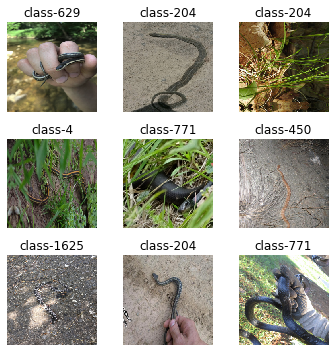

In [7]:
# batch and normalise
data = imagelist.databunch(bs=32).normalize(imagenet_stats)

# visualise
data.show_batch(3, figsize=(5, 5))

**Create Learner & Train**

In [8]:
# # >>> CHOOSE OPTIMIZER
# opt_func = partial(torch.optim.RMSprop),
# opt_func = partial(Ranger),
opt_func = partial(RAdam)

# Create learner
learn = Learner(
    data, model,
    loss_func=LabelSmoothingCrossEntropy(),
    opt_func=opt_func,
    metrics=[accuracy, FBeta(beta=1, average='macro')]
)

# Create subgroups within the model, WHY? Seems to work without this...
learn = learn.split([
    [learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:8]],
    [learn.model._blocks[8:], learn.model._conv_head], 
    [learn.model._bn1, learn.model._fc]]
)

# learn.fit(40, lr=1e-3, wd=1e-5)
# learn.fit_one_cycle(40, max_lr=slice(lr/100,lr))  # should not use with RAdam

# saved_learner = learner.save(save_learner, return_path=True) # saves model & opts, so access model with pytorch.load(...)['model']

-----------------------------
# Visualisation - Class Specific Image Generation

In [8]:
def generate_class_specific_image(model, target_class, steps=100, lr=5, weight_decay=5e-3, random=False, show=True):
    """
    Optimizes an input to maximize the specified output value.
    
    Based on: https://github.com/utkuozbulak/pytorch-cnn-visualizations
    Original was slow and didnt do computation on the GPU
    """
    from misc_functions import preprocess_image, recreate_image

    device = torch.device('cuda')
    
    if random:
        processed_image = np.uint8(np.random.uniform(0+96, 255-96, (224, 224, 3)))
        processed_image = preprocess_image(processed_image, False)
    else:
        processed_image = get_random_img().data[None,...]

    # vars
    mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225])
    clamp_min, clamp_max = ((0-mean)/std).to(device), ((1-mean)/std).to(device)

    # evaluation mode
    model = model.to(device)
    model.eval()

    # optimise image iteratively
    for i in range(1, steps+1):
        try:
            # recreate fresh processed_image
            processed_image = torch.autograd.Variable(processed_image.to(device), requires_grad=True)
            
            # define optimizer over the image | need to do this each time because the image is re-created
            # optimizer = RAdam([processed_image], lr=lr, weight_decay=weight_decay)
            optimizer = torch.optim.SGD([processed_image], lr=lr, weight_decay=weight_decay)

            # forward & get loss for specific class
            output = model(processed_image)
            class_loss = -output[0, target_class]

            # Optimize Step
            model.zero_grad()
            class_loss.backward()
            optimizer.step()
    
            # Clamp Image
            processed_image = torch.max(torch.min(processed_image.permute(0,2,3,1), clamp_max), clamp_min).permute(0,3,1,2)
            
            # Display Image & INFO
            if show and i % 10 == 0:
                plt.imshow(recreate_image(processed_image.cpu()))
                plt.title(f'Class: {target_class} Iteration: {i} Loss {class_loss.cpu():.2f}')
                plt_show_loop()
        except KeyboardInterrupt:
            break
    return recreate_image(processed_image.cpu())

In [895]:
# model = EfficientNet.from_pretrained(model_name)
# model = torchvision.models.resnet18(pretrained=True)
# model = torchvision.models.alexnet(pretrained=True)

model = make_model(load=True)
n = SSIC.num_classes

class_specific_images = []
for i in range(n):
    print(f'Processing Class: {i}')
    set_random_seed(90)
    img = generate_class_specific_image(model, i, steps=300, lr=3, weight_decay=1e-3, random=True, show=False) # show=True slows down the loop with each iteration, this wont finish otherwise.
    class_specific_images.append(img)

print(f'Finished!')

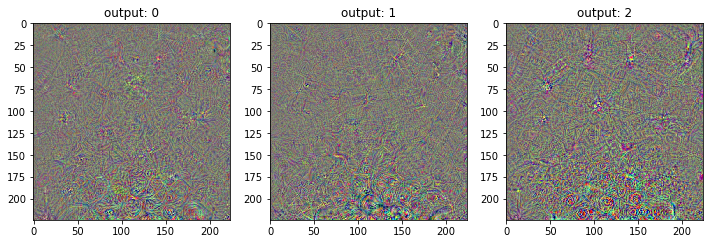

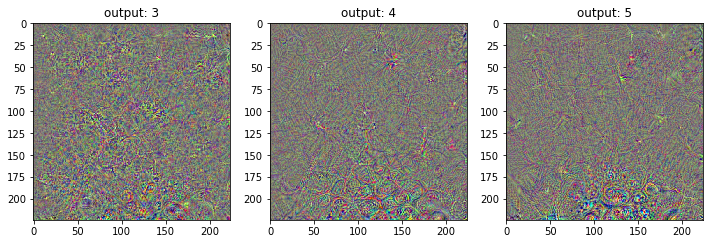

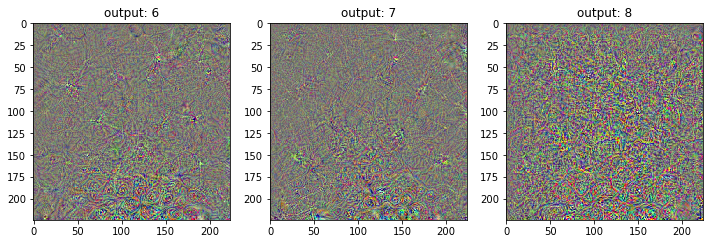

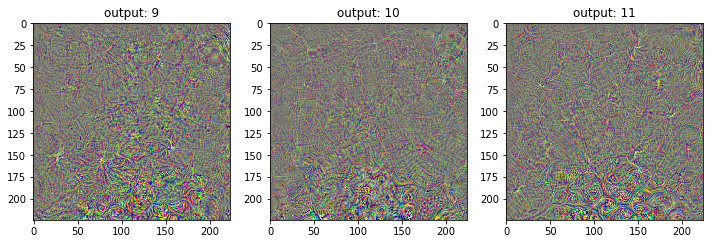

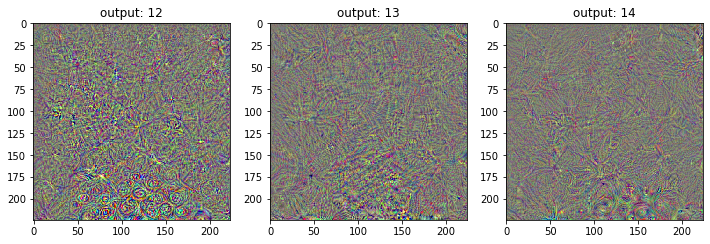

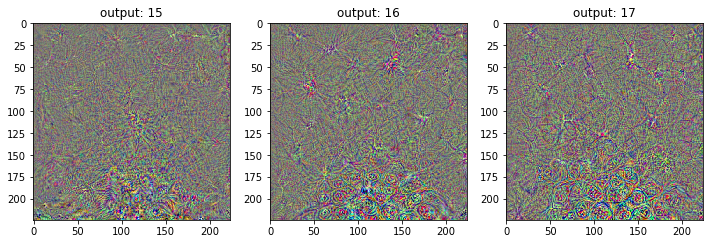

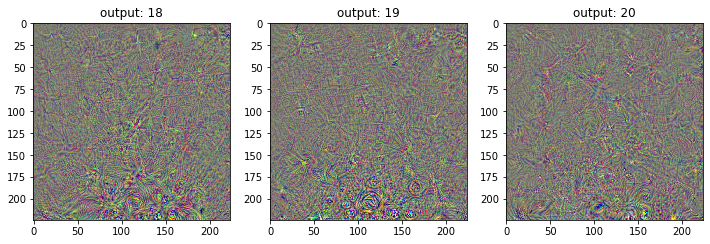

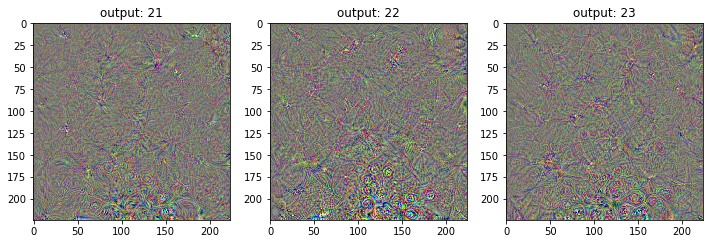

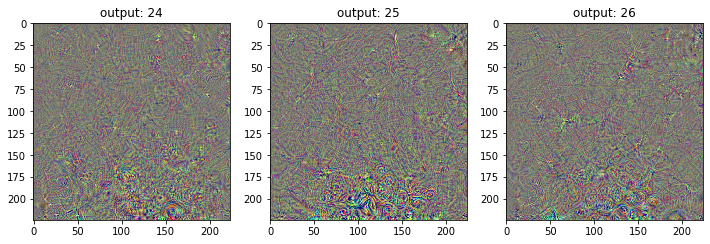

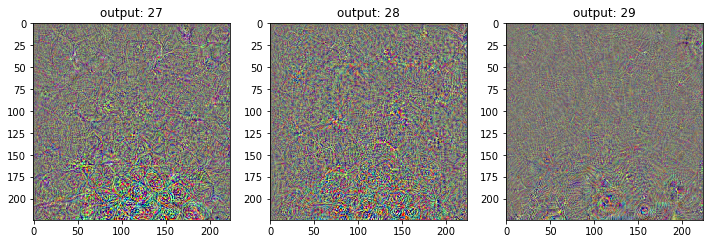

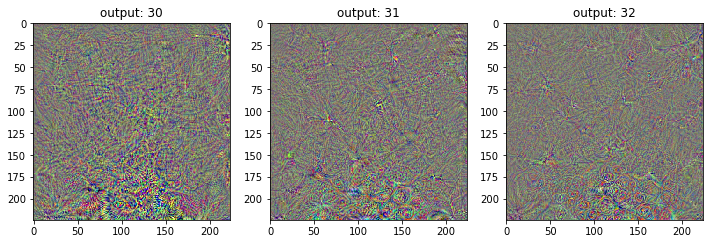

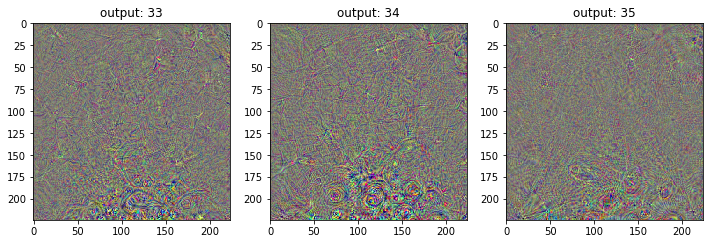

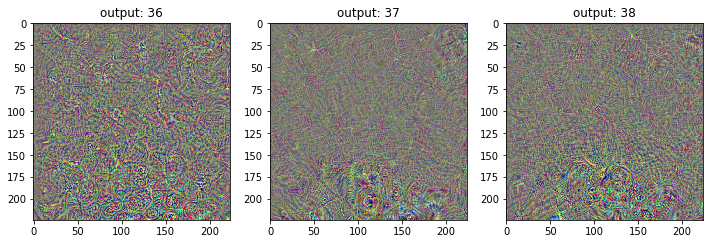

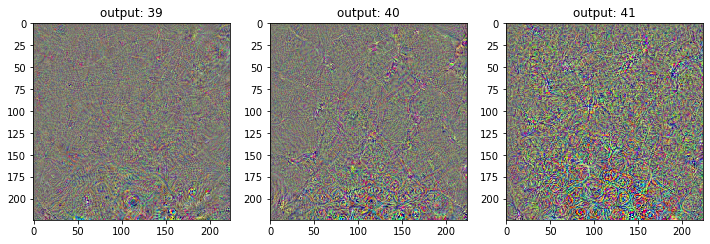

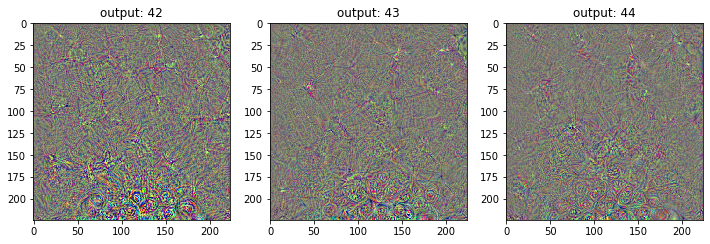

In [894]:
cols, j = 3, 0
for i in range((len(class_specific_images)+cols-1)//cols):
    fig, axs = plt.subplots(1, cols, figsize=(12, 4))
    for ax, img in zip(axs.flatten(), class_specific_images[i*cols:(i+1)*cols]):
        ax.imshow(img)
        ax.set_title(f'output: {j}')
        j += 1
    plt.show()

**2. Occlusion**

In [9]:
def occlusion_sensitivity(
    model, images, mean=None, patch=35, stride=1, n_batches=128, #, ids
):
    """
    BASED ON: https://github.com/kazuto1011/grad-cam-pytorch/blob/master/grad_cam.py
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline scores without occlusion
    # baseline = model(images)
    # baseline = prediction.detach().gather(1, ids)  # fill entire vector with prediction value for that class_id
    
    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        # batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            # batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        # batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images)
        # scores = scores.detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    scoremaps = torch.cat(scoremaps, dim=0)
    # diffmaps  = scoremaps - baseline
    # diffmaps = diffmaps.view(B, new_H, new_W, -1)
    scoremaps = scoremaps.view(B, new_H, new_W, -1)

    return scoremaps

In [31]:
# model = EfficientNet.from_pretrained(model_name)
# model = torchvision.models.alexnet(pretrained=True)
# model = torchvision.models.googlenet(pretrained=True)

model = make_model(load=True)

# Get random image from dataset, includes transforms, etc
imgs = get_random_img().data[None]
outs = model.forward(imgs)

# Get prediction
preds = torch.argmax(outs, axis=1)

# Generate occlusion values. (An image with a number of chanels equal to the model outputs)
# Each channel corresponds to neuron activations
# Visualise by plotting a single output channel.
scoremaps = occlusion_sensitivity(model, imgs, stride=8, patch=32, n_batches=64)

Loaded pretrained weights for efficientnet-b0



100%|██████████| 14/14 [00:43<00:00,  2.42s/it]
                                               

In [36]:
import ipywidgets

@ipywidgets.interact(i=ipywidgets.IntSlider(min=0, max=SSIC.num_classes-1, step=1, value=preds[0]))
def plot_scoremap(i):
    cam = scoremaps[0, :, :, i].data.numpy()
    cam = cv2.resize(cam, (224, 224))

    # create overlay
    cam_norm = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    overlay = plt.cm.viridis(cam_norm)
    overlay[:, :, 3] = cam_norm

    # Show
    plt.imshow(imgs[0].permute(1, 2, 0))
    plt.imshow(overlay, alpha=0.75)
    plt.show()

interactive(children=(IntSlider(value=4, description='i', max=44), Output()), _dom_classes=('widget-interact',…